In [1]:
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
infile = '../ChronoLSTM_1d_bin3/DATA_Linear/xvyw1beta9.5gammax1.0gammay1.0epsln1.0sgma1.0A1.0x01.122w0.8B0.15a1.0_h0.01_mix1.txt'
input_x, _=np.loadtxt(infile, unpack=True, max_rows=100000)

In [3]:
device = torch.device("cpu")

In [4]:
num_bins=3
sm_length=20
def running_mean(x, N):
    """Use convolution to do running average."""
    return np.convolve(x, np.ones((N,))/N, mode='valid')

def find_nearest(key_arr, target):
    """key_arr: array-like, storing keys.
       target: the value which we want to be closest to."""
    idx=np.abs(key_arr-target).argmin()
    return idx

def Rm_peaks_steps(traj):
    global threshold
    """
    Remove sudden changes in the trajectory such as peaks and small steps.
    In this method, I used gradient to identify the changes. If two nonzero
    gradients are too close (< threshold), we shall take this range as noise.
    """
    traj=np.array(traj)
    grad_traj=np.gradient(traj) # gradient of trajectory
    idx_grad=np.where(grad_traj!=0)[0]
    threshold=20
    idx0=idx_grad[0]
    for idx in idx_grad:
        window=idx-idx0
        if window <= 1: # neighbor
            continue
        elif window > 1 and window <= threshold:
            traj[idx0:idx0+window//2+1]=traj[idx0]
            traj[idx0+window//2+1:idx+1]=traj[idx+1]
            idx0=idx
        elif window > threshold:
            idx0=idx
    return traj




X = [1.5, 0, -1.5]
input_x = running_mean(input_x, sm_length) # smooothen data.
idx_x = map(lambda x: find_nearest(X, x), input_x) # convert to three bins.

idx_2d=list(idx_x) # list(zip(idx_x, idx_y))
idx_2d = Rm_peaks_steps(idx_2d) # remove peaks and short steps

text = idx_2d


all_combs = [i for i in range(num_bins)]
vocab=sorted(all_combs)

In [5]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])


In [6]:
text_as_int

array([0, 0, 0, ..., 2, 2, 2])

In [12]:
class NLP(nn.Module):
    
    def __init__(self, input_dim, embedding_dim, rnn_units):
        
        super(NLP, self).__init__()
        
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = rnn_units
        
        
        self.embedding = nn.Embedding(self.input_dim, self.embedding_dim)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.input_dim)
        
    def forward(self, input):
        
        self.batch_size=input.shape[0]
        
        embedding_out = self.embedding(input)
        lstm_out, hidden = self.lstm(embedding_out.view(self.batch_size, input.shape[1], self.embedding_dim))
        y_pred = self.linear(lstm_out)
        
        return y_pred


In [ ]:
embedding = nn.Embedding(vocab_size, embedding_dim)
embedding_out = embedding(batch_X_train)
embedding_out.shape

In [147]:
lstm = nn.LSTM(embedding_dim, rnn_units, batch_first=True)
lstm_out = lstm(embedding_out.view(batch_size, 100, embedding_dim))
lstm_out[0].shape

torch.Size([64, 100, 32])

In [13]:
def batch_data(x, batch_size):
    """input should be a numpy.array or list"""
    remaind = len(x)%batch_size
    y = x[:-remaind]
    num_dataset = len(x)//batch_size
    return y.reshape((num_dataset, batch_size))


EPOCHS = 20
sequence_len = 100
shift=1
batch_size=64

X_train = batch_data(text_as_int[:-shift], sequence_len)
X_train = torch.tensor(X_train, device="cpu")
Y_train = batch_data(text_as_int[shift:], sequence_len)
Y_train = torch.tensor(Y_train, device="cpu")

# Length of the vocabulary in chars
vocab_size = len(vocab)
# The embedding dimension
embedding_dim = 8
# Number of RNN units
rnn_units = 32
# Batch size
batch_size=64

model = NLP(vocab_size, embedding_dim, rnn_units).to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(EPOCHS):
    
    permutation = torch.randperm(X_train.shape[0])

    for i in range(0, X_train.shape[0]-batch_size, batch_size):
#         print(i)
        indices = permutation[i:i+batch_size]
#         print(indices)
        batch_X_train, batch_Y_train = X_train[indices], Y_train[indices]
        batch_X_train = batch_X_train.to(device)
        batch_Y_train = batch_Y_train.to(device)
        y_pred = model(batch_X_train)
        y=batch_Y_train.to(device)
#         print(y_pred.shape)
#         print(y.shape)
        loss = loss_fn(y_pred.view(-1, vocab_size), y.view(-1))
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(epoch, loss.item())
    

NLP(
  (embedding): Embedding(3, 8)
  (lstm): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
)
0 1.024482011795044
1 0.8447785377502441
2 0.5905354022979736
3 0.39247801899909973
4 0.2842410206794739
5 0.22936969995498657
6 0.18886472284793854
7 0.15620164573192596
8 0.1464516520500183
9 0.1292848289012909
10 0.12724429368972778
11 0.12661154568195343
12 0.11562281847000122
13 0.1094169169664383
14 0.10147712379693985
15 0.09958842396736145
16 0.09553944319486618
17 0.09549863636493683
18 0.07965468615293503
19 0.09080754965543747


# Prediction

In [219]:
def generate_text(start_string):
    
    input_eval = torch.tensor([char2idx[s] for s in start_string], device=device)
    
    text_generated = np.empty(1)
    for i in range(1000):
        input_eval = input_eval[np.newaxis, ...] # add a dimension for batch=1.
        prediction=model(input_eval)
        logits=prediction
        p=torch.nn.functional.softmax(logits,dim=-1) 
        predicted_id=torch.multinomial(p[0,-1], 1) # take first batch
        
        input_eval = predicted_id
        
        text_generated = np.vstack((text_generated, idx2char[predicted_id].tolist()))

    return text_generated

In [220]:
text = idx_2d[:1000]
prediction=generate_text(text)

In [3]:
infile = 'prediction'
prediction=np.loadtxt(infile)

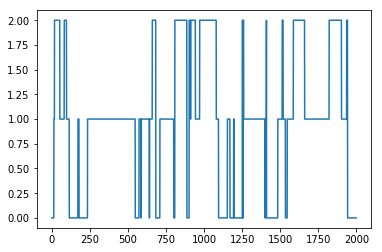

In [17]:
import matplotlib.pyplot as plt
plt.plot(prediction[1:2000])
plt.show()

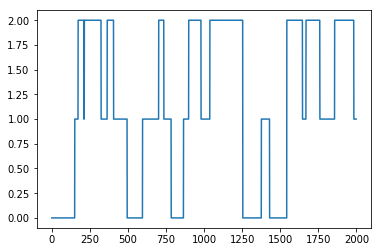

In [16]:
plt.plot(text_as_int[1:2000])

In [7]:
np.where(prediction==0)[0].shape

(10990,)

In [8]:
np.where(prediction==1)[0].shape

(17243,)

In [9]:
np.where(prediction==2)[0].shape

(11767,)